In [305]:
import itertools
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation
from prophet.make_holidays import *
from prophet.diagnostics import performance_metrics
import numpy as np
import pandas as pd
import cmdstanpy
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt


# Blocks FutureWarning messages about soon to be deprecated features
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import dask
from distributed import Client, performance_report

#### Section 1: Deta Prep
1. Converting the date column from the csv to datetime is necessary for Prophet to run.
2. The date columns must be in 2023-12-31 format.
3. The revenue column should be renamed to 'y' and the date column should be renamed to 'ds'.
4. Forecast works well with simply the date and revenue, but more variables can be added.
5. Promos has several small integers, but is only useful as a binary regressor, so we change anything greater than zero to 1.
6. Data with more dummy variables will provide more accurate results, so we filter out all but the locations with the higest number of promos.
7. We can then select a location to run Prophet on.

Important links:
Official Facebook Prophet Doucmentation:https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

In [306]:
df = pd.read_csv('C:/Users/norri/Desktop/tyson_formatted.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [307]:
# This finds any instance of a promo in a store and converts it to 1, so the variable because a dummy variable.
df.sort_values(by=['loc', 'ds'], inplace=True)
df['promos'] = np.where(df['promos'] > 0, 1, df['promos'])

In [308]:
# This groups by location then counts any promos are occurring per location
df.sort_values(by=['loc', 'ds'], inplace=True)
locations = df.groupby('loc')['promos'].sum()
locations = locations[locations == locations.max()]
print(locations)

loc
1579149    3
1579159    3
1579160    3
1579164    3
1579184    3
1579185    3
1579199    3
1579204    3
1579207    3
1579213    3
1579215    3
1579216    3
1579224    3
1579239    3
1579244    3
1579257    3
1579259    3
1579262    3
1579273    3
1579287    3
1579289    3
1579294    3
1579303    3
1579307    3
1579328    3
1579329    3
1579334    3
1579377    3
1579388    3
1579389    3
1579393    3
1579405    3
Name: promos, dtype: int64


In [309]:
# Running Prophet on locations without promotions is useless. The previous code block found the max number of promos per location and make a list.
# from that list we can choose one location to run with Prophet, and drop the location variable for a little more speed
df = df[df['loc'] == 1579262]
df.drop(['loc'], axis=1, inplace=True)

#### Section 2: Prophet Setup and basic checks (skip and comment out after first run)

In [310]:
# This is just initializing the default model and fitting it to our data.
m = Prophet()
m.fit(df)

In [311]:
# Prophet can add more size to a time series dataframe and predict into it, though this simple will not be good
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
575,2024-06-26,35.379852,-6.891244,79.287430
576,2024-06-27,37.295122,-8.139344,80.945228
577,2024-06-28,43.343118,0.057334,84.004220
578,2024-06-29,57.003881,11.952228,97.352782
579,2024-06-30,79.977535,40.131185,125.296533


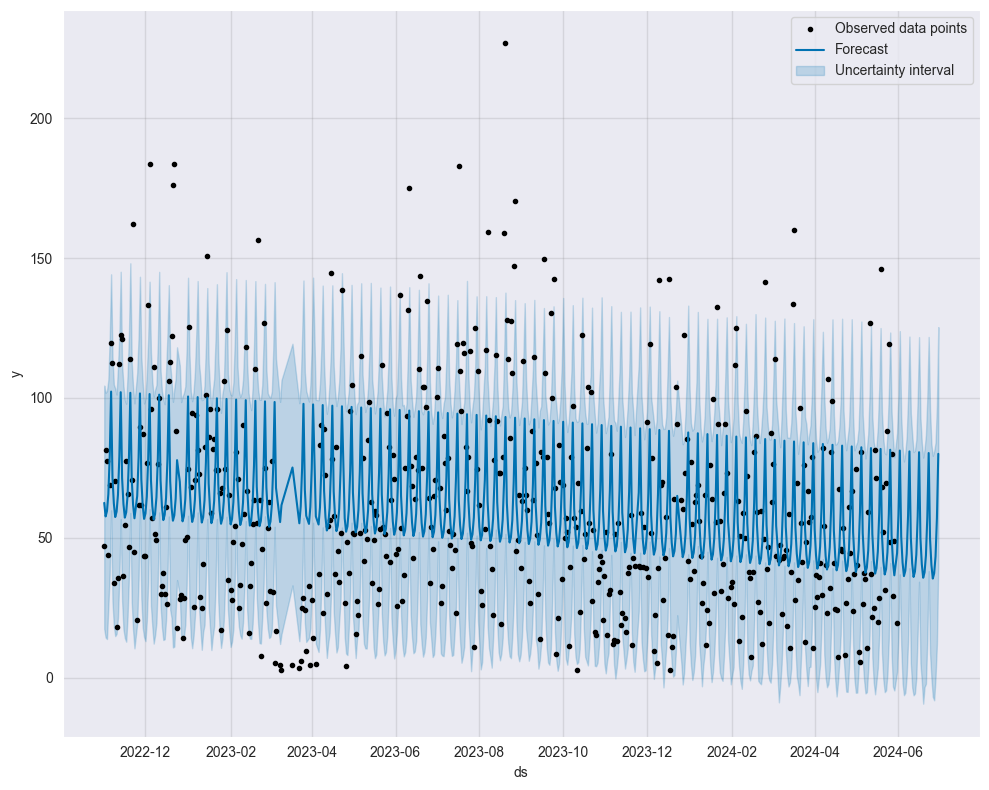

In [312]:
fig_sect2_1 = m.plot(forecast, figsize=(10, 8), include_legend=True)

The pattern to be trending downwards, but there are a few spikes in sales.
plot_components (on the basic model) shows us the historical trend of sales as well as the trend of sales during the week.

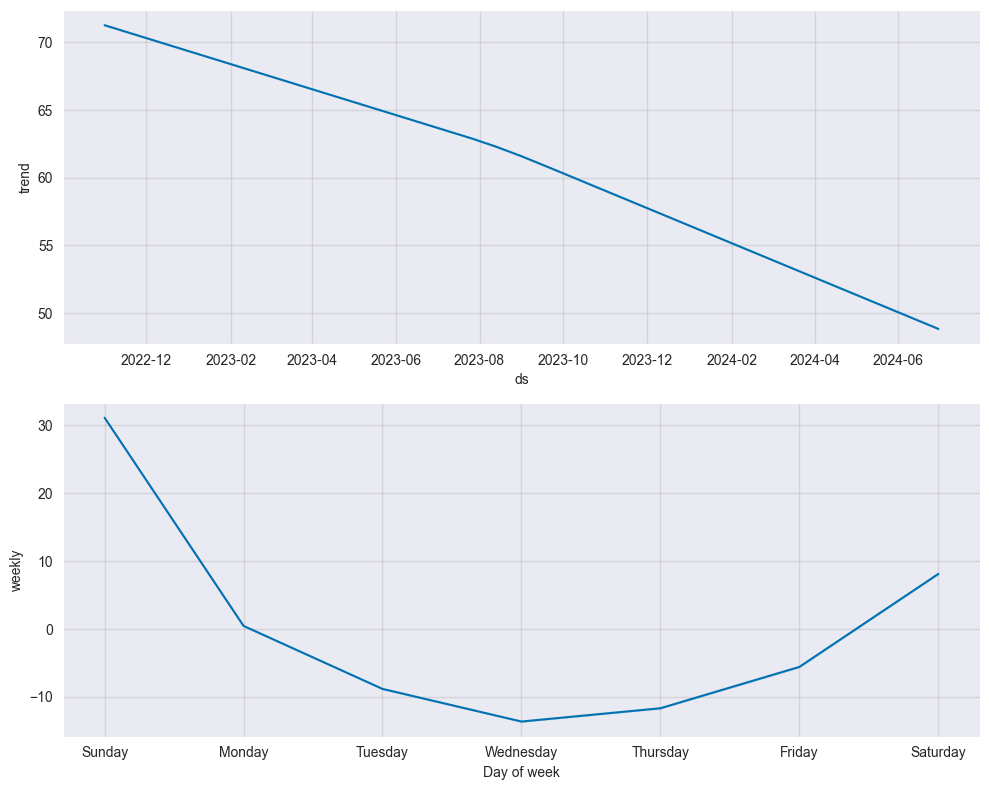

In [313]:
fig_sect2_2 = m.plot_components(forecast, uncertainty=True, figsize=(10, 8))

#### Section 3: Forecasting Growth

In [314]:
# In the case of forecasting growth, determining a method of growth (logistic, linear, etc.) and a theoretical ceiling for growth needs be determined for the forecast. This would require someone familiar on how the team is expected to go.
df['cap'] = 100
m = Prophet(growth='logistic')
m.fit(df)

In [315]:
future = m.make_future_dataframe(periods=90)
future['cap'] = 100

In [316]:
fcst = m.predict(future)

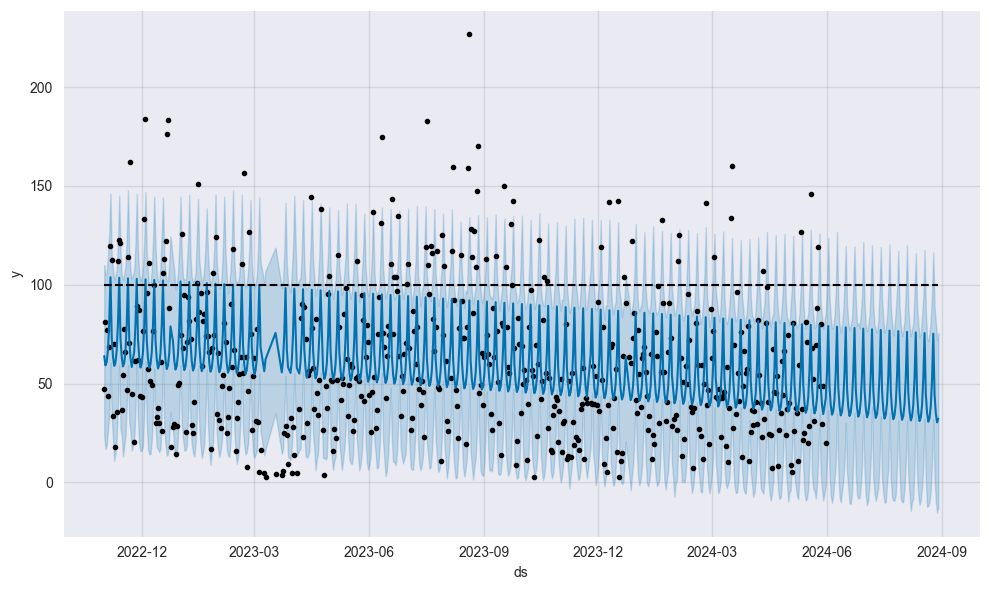

In [317]:
fig = m.plot(fcst)

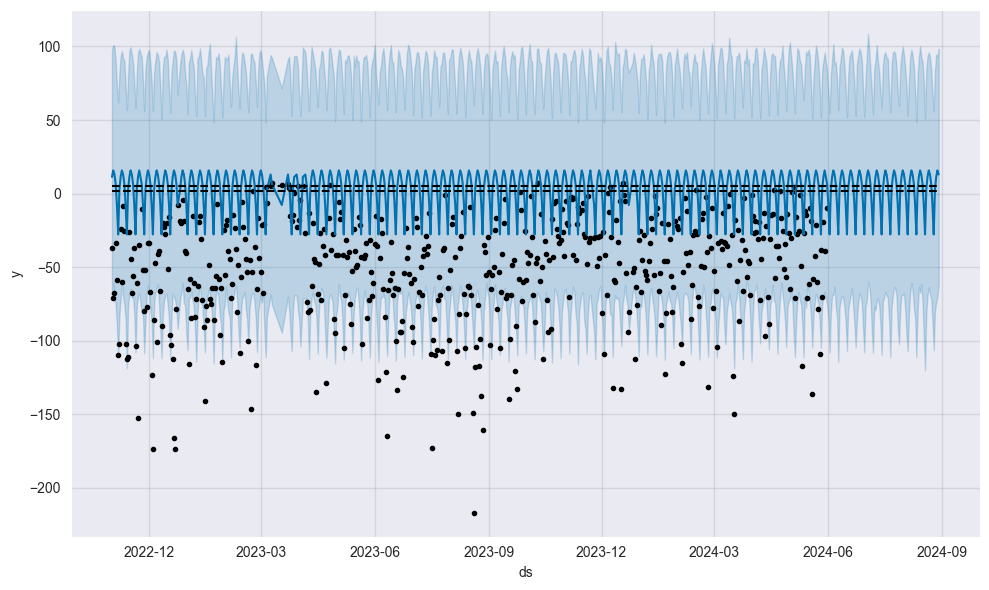

In [318]:
# Similar to the growth ceiling, a floor can also be set by a saturating minimum
df['y'] = 10 - df['y']
df['cap'] = 5
df['floor'] = 2
future['cap'] = 5
future['floor'] = 2
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

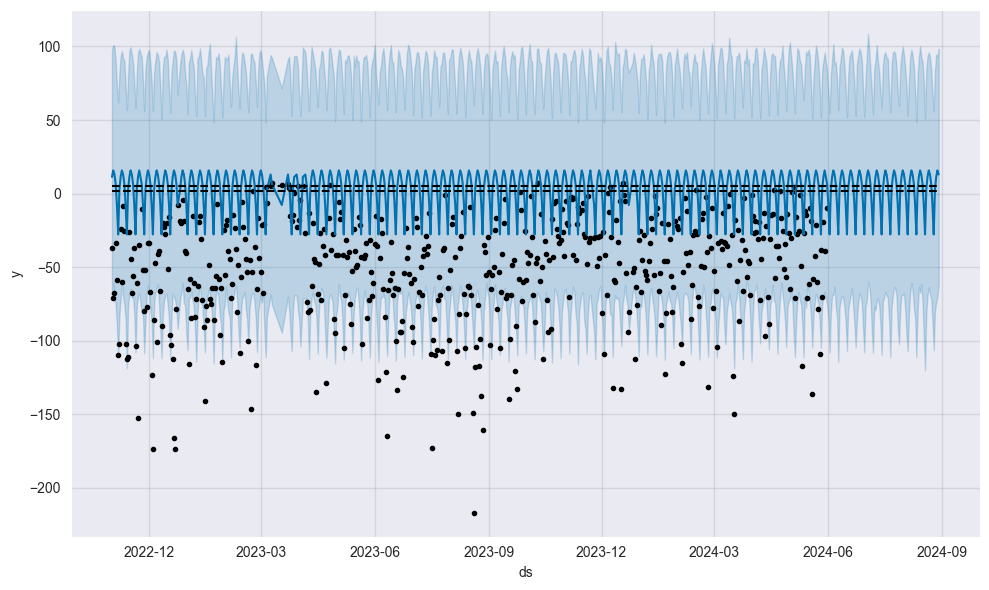

In [319]:
fig = m.plot(fcst)

#### Section 3: Adding Changepoints

Prophet use L1 regularization to detect as many change points where numbers increase or decrease rapidly,
but though it detect quite a few, it generally only uses 20 or 30 changepoints

C:\Users\norri\DataspellProjects\mercury-ds\attribution\Retailyze_Causal\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


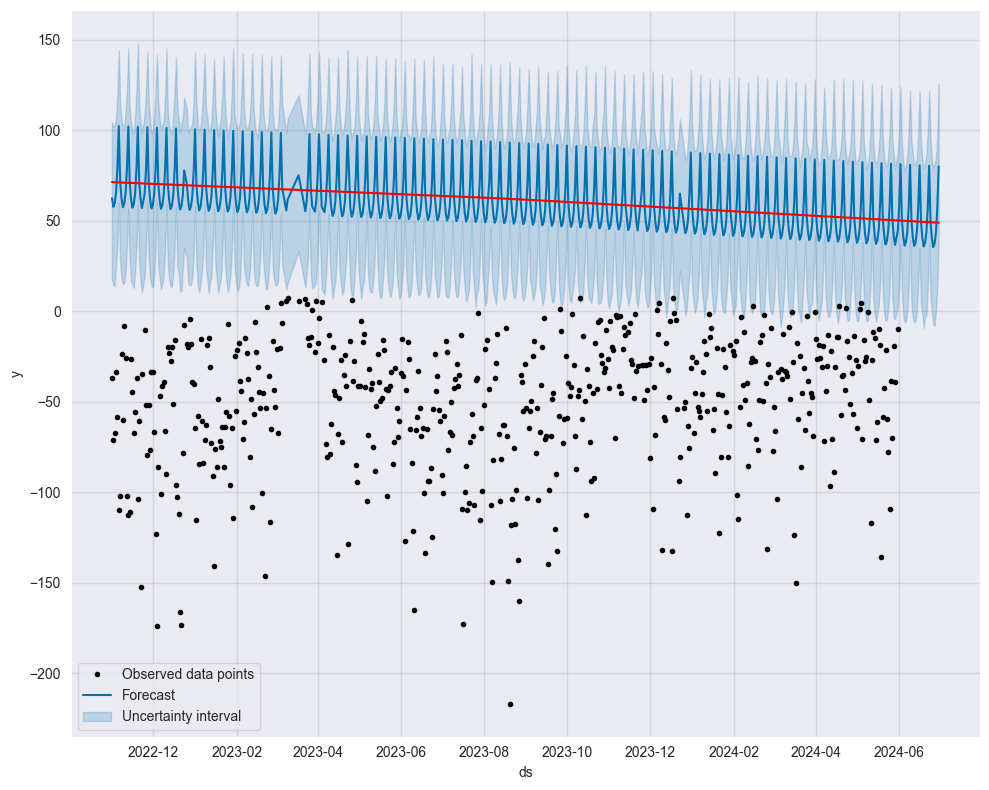

In [320]:
fig =m.plot(forecast, figsize=(10, 8), include_legend=True)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

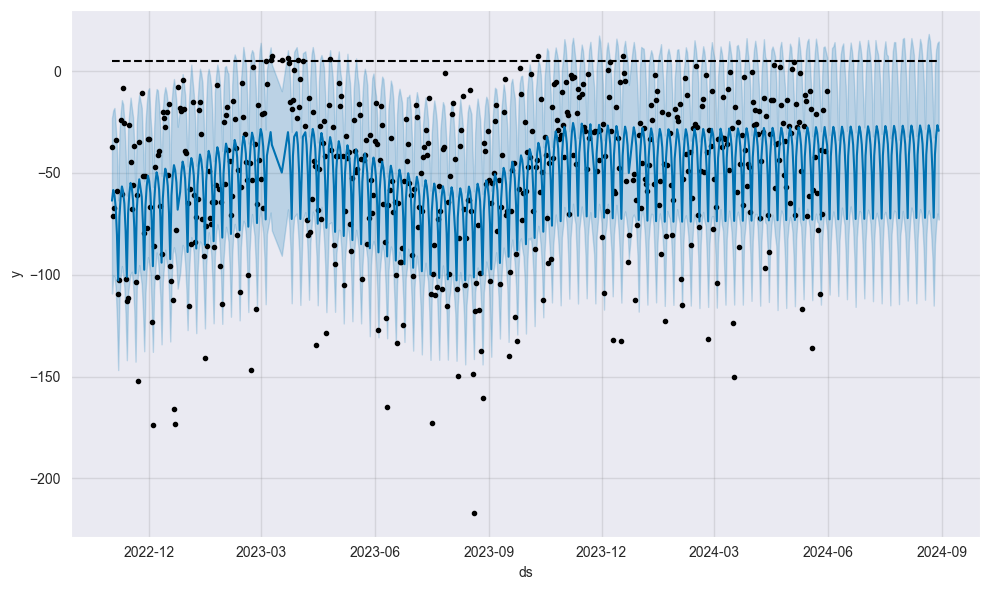

In [321]:
m = Prophet(changepoint_prior_scale=.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

This can be used to modify the trend if it appears to be over or underfitting
?Documentation on cross-validation for further info?

14:07:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


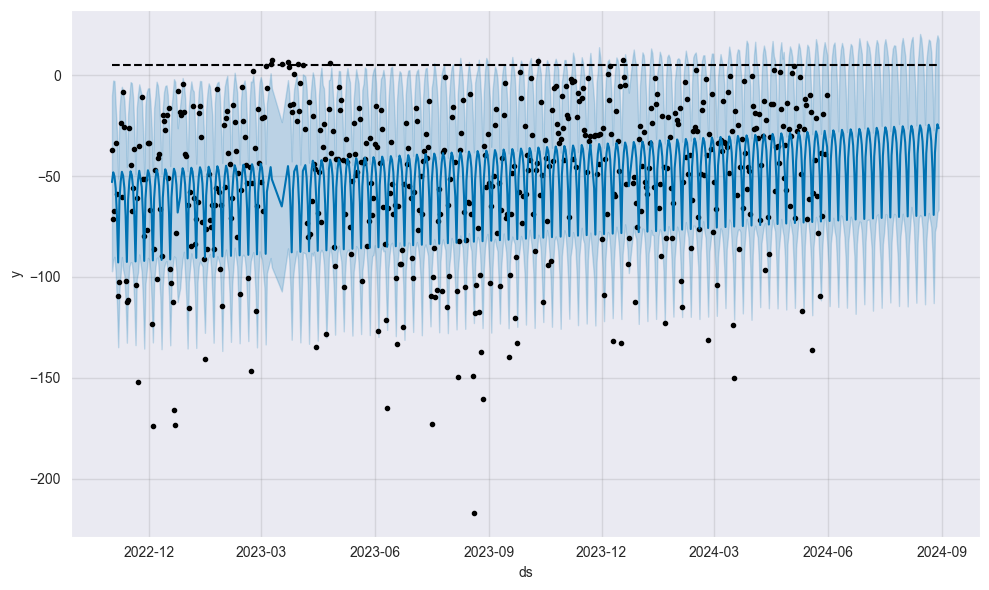

In [322]:
m = Prophet(changepoints='2023-11-01')
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

With some experience, you can examine such charts to determine if the priors should change.

#### Seasonality and Holidays

In [323]:
# To add custom holidays make a two-column dataframe such as this
# the lower window can be set to -1 or lower and upper window to 1 or higher
# to extend a holiday effect 

promos = pd.DataFrame({
  'holiday': 'promos',
  'ds': pd.to_datetime(['2024-01-19', '2024-01-20', '2024-01-21',
                        '2024-01-22', '2024-01-23', '2024-01-24',
                        '2024-01-25', '2024-01-26', '2024-01-27',
                        '2024-01-28', '2024-03-29', '2024-03-30',
                        '2024-03-31', '2024-04-05', '2024-04-06',
                        '2024-04-07',]),
  # DEFINE THIS  
  # 'lower_window': 0,
  # 'upper_window': 1,
})

In [324]:
m = Prophet(holidays=promos)

In [325]:
forecast = m.fit(df).predict(future)

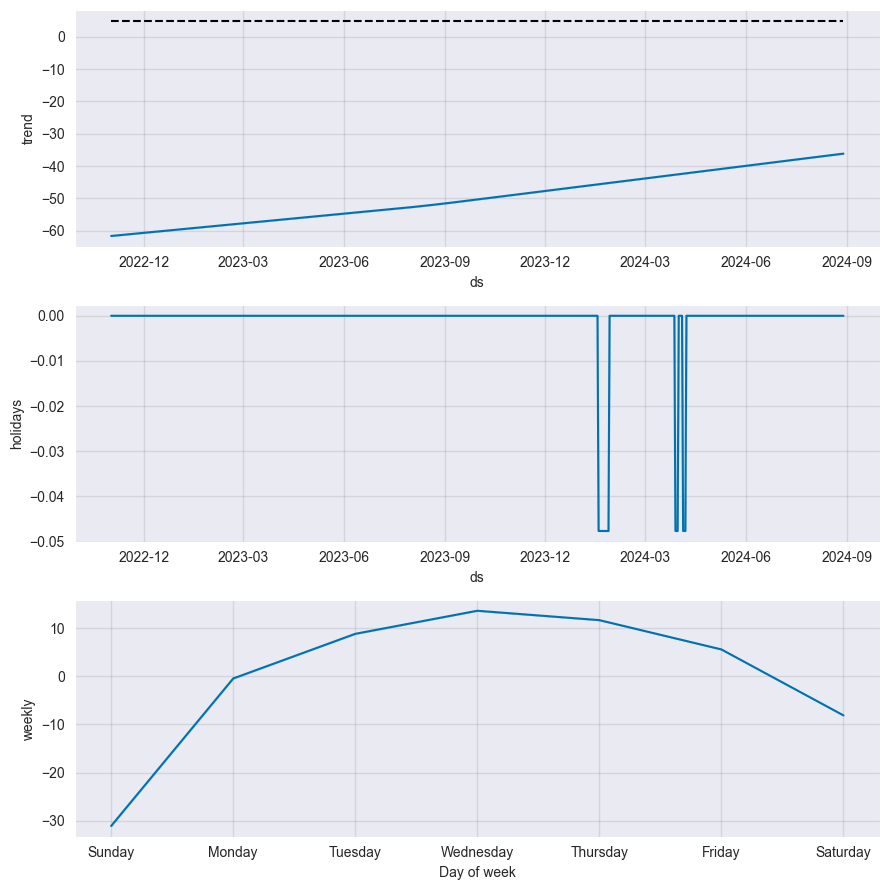

In [326]:
fig = m.plot_components(forecast)

In the documentation, there are also ways to use holidays for different regions.

#### Section 5: Seasonalities

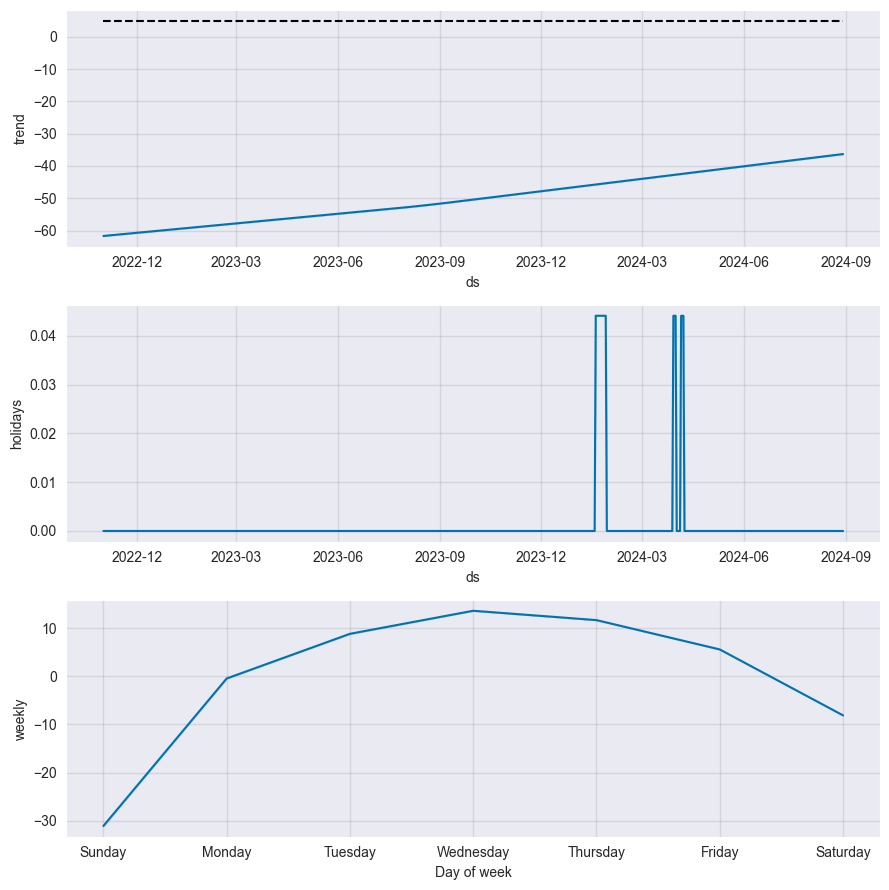

In [327]:
m = Prophet(holidays=promos, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
fig = m.plot_components(forecast)

There are significant differnces in the latest and the previous holidays run, so modifying this can big effects.

Seasonalities are made from partial Fourier sums, and while those estimates are usually appropriate, the periodic frequency can be modified
Custom seasonalities, seasonalities determined by irregular cycles, and prior scales for holidays and seasonality can also be adjusted if
overfitting or underfitting is suspected

#### Section 7: Uncertainty

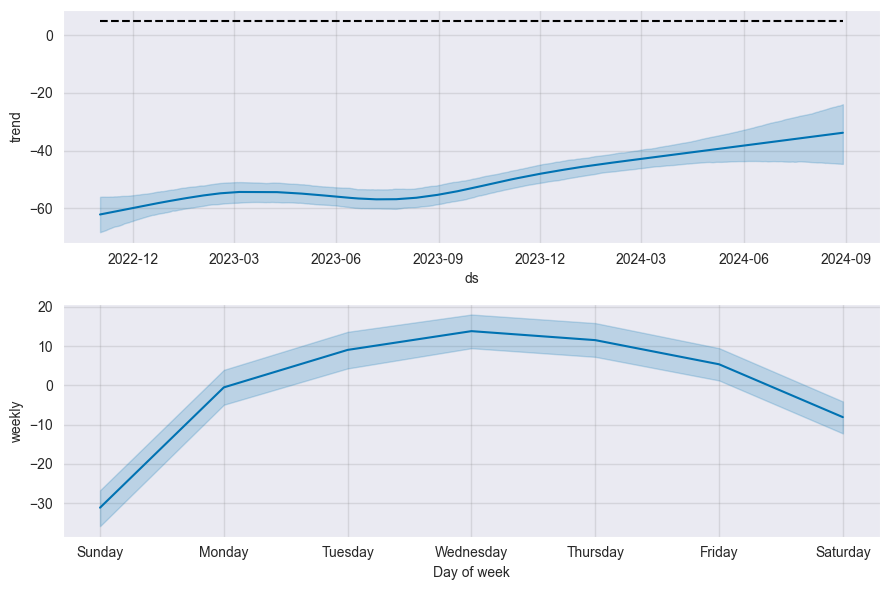

In [328]:
forecast = Prophet(interval_width=0.95).fit(df).predict(future)
m = Prophet(mcmc_samples=300)
forecast = m.fit(df, show_progress=False).predict(future)
fig = m.plot_components(forecast)

They look similar to other charts but the bands around them illustrate how much risk is involved,

#### Section 73: The final model

We will add the regressor along with creating our final Prophet model. 

In [329]:
holidays = make_holidays_df([2019, 2020, 2021, 2023, 2024], 'US') # this to cover up the promos field from eariler in the program

In [330]:
# Hides the many rows of MCMC runs
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.ERROR)

There are many parameters in this Prophet, most of which has been covered. The add_regressor is what allows us to have promos in our test, and interval_width, mcmc_samples, and uncertainty samples are what turns this function in a Bayesian analysis.

In [331]:
m = Prophet(daily_seasonality='auto', holidays=holidays, changepoint_prior_scale=.02, seasonality_mode='additive',
            seasonality_prior_scale=1.05, interval_width=0.90, mcmc_samples=25000,
            uncertainty_samples=2000).add_regressor('promos', standardize='False', mode='additive')
m.fit(df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [332]:
# As MCMC chains can often be inaccurate, it is vital to test them, no matter big you make your parameters
print(m.stan_fit.diagnose())

Processing csv files: C:\Users\norri\AppData\Local\Temp\tmpzvlo4s3_\prophet_modely4nh21gr\prophet_model-20240701141541_1.csv, C:\Users\norri\AppData\Local\Temp\tmpzvlo4s3_\prophet_modely4nh21gr\prophet_model-20240701141541_2.csv, C:\Users\norri\AppData\Local\Temp\tmpzvlo4s3_\prophet_modely4nh21gr\prophet_model-20240701141541_3.csv, C:\Users\norri\AppData\Local\Temp\tmpzvlo4s3_\prophet_modely4nh21gr\prophet_model-20240701141541_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Even though the previous test almost always comes back passing, if the Hamiltonian Monte Carlo through and error it could distort the model badly,

This is the most important of the test because it answers our question: do our people benefit their clients?
To briefly explain, Bayesian methods differ from classical statistics. When we ran our final model, we answered the question as Bayesian would.
Remember the interval we set at 90% in the Prophet Model? Now the Bayesian identified the coef, but it isn't significant if it's lower coefficient 
The way this would refer to this test is promos is estimated to $57.61 throgh promos, and the 90% credible interval is all but truth it is true,

In [333]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,promos,additive,0.005455,-90.611966,-57.750407,-25.230872


To make another forecast from the future dataframe, the extra regressor values must either be known or forecasted themselves. In this case, since most promos values were 0, filling with zeros is acceptable due to the small size the window. For non-binary regressors, a better solution is needed.

In [ ]:
future = m.make_future_dataframe(periods=30)
future['promos'] = df['promos']
future = future.fillna(0)
forecast = m.predict(future)
fig = m.plot_components(forecast)

BETTER The beta coefficients can be pulled, and if MCMC samples is specified, a credible interval can be determined for each coefficient, which can tell us is that regressor is meaningful

#### Section 8: Prophet Model Diagnostics

In [ ]:
# client = Client(threads_per_worker=1)
# client

In [ ]:
df_cv = cross_validation(m, initial='350 days', horizon='35 days', period='70 days', parallel='dask')

param_grid = {
    'changepoint_prior_scale': [0.02, 0.03, 0.04, 0.05],
    'seasonality_prior_scale': [0.9, 1.05, 1.1, 1.2],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='350 days', horizon='35 days', period='70 days', parallel='dask')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

This section sets all the parameters for the Prophet model. Setting the growth as linear for now, but worth experimenting with. Changepoints are locations where the rate of change is potentially allowed to change.
The yearly, weekly, and daily seasonality are set here as auto for yearly and weekly, so Prophet can detect it, and daily for false, so it doesn't detect any false readings. Seasonality mode is defined to as either additive or multiplicative for better fitting.
The following parameters are set to avoid overfitting. Note that at the end of the notebook there is a bit that runs a check on the priors.
Fit should be set to false to add extra regressors.

This is the Prophet class with all of its potential parameters. Below that, is a good amount of causal inference attempts that were fruitless without more data.

In [ ]:
# m = Prophet(growth = 'linear',
#             n_changepoints = 25,
#             changepoint_range = 0.8,
#             yearly_seasonality = 'auto',
#             weekly_seasonality = 'auto',
#             daily_seasonality = 'auto',
#             holidays = promos,
#             seasonality_mode = 'additive',
#             seasonality_prior_scale = 10.0,
#             holidays_prior_scale = 10.0,
#             changepoint_prior_scale = 0.05,
#             mcmc_samples = 800,
#             interval_width = 0.20,
#             uncertainty_samples = 500)
#             stan_backend = 'False')
#             fit = False)


In [ ]:
# df = pd.read_csv('C:/Users/norri/Desktop/tyson2.csv')
# df.sort_values(by=['loc', 'y'], inplace=True)
# df.sort_values(by=['loc', 'y'], inplace=True)
# df1 = df[df['promos'] > 0]
# locations = df1.groupby('loc')['promos'].sum()
# locations = locations[locations == locations.max()]
# print(locations)
# df = df[df['loc'] == 1579164]
# # df.drop(['loc'], axis=1, inplace=True)
# df = df[df['ds'] > '2023-11-01']
# df['promos'] = np.where(df['promos'] > 0, 1, df['promos'])

In [ ]:
# import bnlearn as bn
# # Load sprinkler dataset
# df = bn.import_example('sprinkler')
# # Print to screen for illustration
# print(df)

In [ ]:
# # Learn the DAG in data using Bayesian structure learning:
# DAG = bn.structure_learning.fit(df)
# 
# # print adjacency matrix
# print(DAG['adjmat'])
# # target     Cloudy  Sprinkler   Rain  Wet_Grass
# # source                                        
# # Cloudy      False      False   True      False
# # Sprinkler    True      False  False       True
# # Rain        False      False  False       True
# # Wet_Grass   False      False  False      False
# 
# # Plot
# G = bn.plot(DAG)
# 
# # Interactive plotting
# G = bn.plot(DAG, interactive=True)

In [ ]:
# import bnlearn as bn
# # Load sprinkler dataset
# df = bn.import_example('sprinkler')
# # The edges can be created using the available variables.
# print(df.columns)
# # ['Cloudy', 'Sprinkler', 'Rain', 'Wet_Grass']
# 
# # Define the causal dependencies based on your expert/domain knowledge.
# # Left is the source, and right is the target node.
# edges = [('Cloudy', 'Sprinkler'),
#          ('Cloudy', 'Rain'),
#          ('Sprinkler', 'Wet_Grass'),
#          ('Rain', 'Wet_Grass')]
# 
# 
# # Create the DAG
# DAG = bn.make_DAG(edges)
# 
# # Plot the DAG. This is identical as shown in Figure 3
# bn.plot(DAG)
# 
# # Print the Conditional probability Tables
# bn.print_CPD(DAG)
# # [bnlearn] >No CPDs to print. Tip: use bnlearn.plot(DAG) to make a plot.
# # This is correct, we did not learn any CPTs yet! We only defined the graph without defining any probabilities.
# 
# # Parameter learning on the user-defined DAG and input data using maximumlikelihood
# model_mle = bn.parameter_learning.fit(DAG, df, methodtype='maximumlikelihood')
# 
# # Print the learned CPDs
# bn.print_CPD(model_mle)
# 
# # CPD of Cloudy:
# # +-----------+-------+
# # | Cloudy(0) | 0.488 |
# # +-----------+-------+
# # | Cloudy(1) | 0.512 |
# # +-----------+-------+
# # CPD of Rain:
# # +---------+---------------------+-------------+
# # | Cloudy  | Cloudy(0)           | Cloudy(1)   |
# # +---------+---------------------+-------------+
# # | Rain(0) | 0.8073770491803278  | 0.177734375 |
# # +---------+---------------------+-------------+
# # | Rain(1) | 0.19262295081967212 | 0.822265625 |
# # +---------+---------------------+-------------+
# # CPD of Sprinkler:
# # +--------------+--------------------+------------+
# # | Cloudy       | Cloudy(0)          | Cloudy(1)  |
# # +--------------+--------------------+------------+
# # | Sprinkler(0) | 0.4610655737704918 | 0.91015625 |
# # +--------------+--------------------+------------+
# # | Sprinkler(1) | 0.5389344262295082 | 0.08984375 |
# # +--------------+--------------------+------------+
# # CPD of Wet_Grass:
# # +--------------+--------------+--------------+---------------------+----------------------+
# # | Rain         | Rain(0)      | Rain(0)      | Rain(1)             | Rain(1)              |
# # +--------------+--------------+--------------+---------------------+----------------------+
# # | Sprinkler    | Sprinkler(0) | Sprinkler(1) | Sprinkler(0)        | Sprinkler(1)         |
# # +--------------+--------------+--------------+---------------------+----------------------+
# # | Wet_Grass(0) | 1.0          | 0.15625      | 0.11395348837209303 | 0.023529411764705882 |
# # +--------------+--------------+--------------+---------------------+----------------------+
# # | Wet_Grass(1) | 0.0          | 0.84375      | 0.8860465116279069  | 0.9764705882352941   |
# # +--------------+--------------+--------------+---------------------+----------------------+
# # [bnlearn] >Independencies:
# # (Cloudy _|_ Wet_Grass | Sprinkler, Rain)
# # (Sprinkler _|_ Rain | Cloudy)
# # (Rain _|_ Sprinkler | Cloudy)
# # (Wet_Grass _|_ Cloudy | Sprinkler, Rain)
# # [bnlearn] >Nodes: ['Cloudy', 'Sprinkler', 'Rain', 'Wet_Grass']
# # [bnlearn] >Edges: [('Cloudy', 'Sprinkler'), ('Cloudy', 'Rain'), ('Sprinkler', 'Wet_Grass'), ('Rain', 'Wet_Grass')]


In [ ]:
# from causalimpact import CausalImpact

causalinference

In [ ]:
# from causalinference import CausalModel
# from causalinference.utils import random_data
# #Y is the outcome, D is treatment status, and X is the independent variable
# Y, D, X = random_data()
# causal = CausalModel(Y, D, X)
# print(causal.summary_stats)

In [ ]:
# causal.est_via_ols()
# print(causal.estimates)
# causal.est_propensity_s()
# print(causal.propensity)

causalimpact

In [ ]:
# import numpy as np
# from statsmodels.tsa.arima_process import arma_generate_sample
# from causalimpact import CausalImpact
# np.random.seed(1)
# x1 = arma_generate_sample(ar=[0.999], ma=[0.9], nsample=100) + 100
# y = 1.2 * x1 + np.random.randn(100)
# y[71:100] = y[71:100] + 10
# data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])
# pre_period = [0,69]
# post_period = [71,99]

In [ ]:
# impact = CausalImpact(data, pre_period, post_period)
# impact.run()
# impact.plot()

In [ ]:
# impact.summary()

In [ ]:
# impact.summary(output = 'report')

DoWhy

In [ ]:
# from dowhy import CausalModel
# import dowhy.datasets
# # Load some sample data
# data = dowhy.datasets.linear_dataset(
#     beta=10,
#     num_common_causes=5,
#     num_instruments=2,
#     num_samples=10000,
#     treatment_is_binary=True)

In [ ]:
# #Create a causal model from the data and given graph.
# model = CausalModel(
#     data=data["df"],
#     treatment=data["treatment_name"],
#     outcome=data["outcome_name"],
#     graph=data["gml_graph"])
# model.view_model()

In [ ]:
# #Identify the causal effect
# estimands = model.identify_effect()

In [ ]:
# estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")

In [ ]:
# refute_results = model.refute_estimate(identified_estimand, estimate,                                     method_name="random_common_cause")

more causal impact

In [ ]:
# from causalimpact import CausalImpact
# import numpy as np
# import pandas as pd
# from statsmodels.tsa.arima_process import arma_generate_sample
# import matplotlib
# %matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (15, 6)
# 
# np.random.seed(1)
# 
# x1 = arma_generate_sample(ar=[0.999], ma=[0.9], nsample=100) + 100
# y = 1.2 * x1 + np.random.randn(100)
# 
# y[71:100] = y[71:100] + 10
# data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"]).astype(float)
# pre_period = [0,69]
# post_period = [71,99]
# impact = CausalImpact(data, pre_period, post_period)

In [ ]:
# data.plot();

In [ ]:
# impact.run()

In [ ]:
# date_range = pd.date_range(start="2014-01-01", periods=100)
# ts_data = data.copy()
# ts_data.index = date_range
# ts_data.head()

In [ ]:
# ts_pre_period = [pd.to_datetime(date) for date in ["2014-01-01", "2014-03-12"]]
# ts_post_period = [pd.to_datetime(date) for date in ["2014-03-13", "2014-04-10"]]

In [ ]:
# ts_impact = CausalImpact(ts_data, ts_pre_period, ts_post_period)
# ts_impact.run()

pgmpy

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from networkx import draw_networkx, DiGraph
# 
# from causalnex.structure.notears import from_pandas
# from pgmpy.models import BayesianNetwork
# from pgmpy.factors.discrete import TabularCPD
# from pgmpy.inference import VariableElimination
# from pgmpy.factors.discrete import DiscreteFactor

tccausal

In [ ]:
# %matplotlib inline
# 
# import sys
# import os
# import warnings
# import logging
# 
# 
# 
# logging.getLogger('tensorflow').setLevel(logging.FATAL)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# warnings.filterwarnings("ignore")
# sys.path.append(os.path.abspath('../'))
# 
# 
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import tensorflow_probability as tfp
# import matplotlib.pyplot as plt
# from causalimpact import CausalImpact
# 
# 
# tfd = tfp.distributions
# plt.rcParams['figure.figsize'] = [15, 10]

In [ ]:
# def plot_time_series_components(ci):
#     # https://github.com/tensorflow/probability/blob/v0.16.0/tensorflow_probability/python/sts/decomposition.py#L165-L195
#     component_dists = tfp.sts.decompose_by_component(ci.model, ci.observed_time_series, ci.model_samples)
#     num_components = len(component_dists)
#     xs = np.arange(len(ci.observed_time_series))
#     fig = plt.figure(figsize=(12, 3 * num_components))
#     mu, sig = ci.mu_sig if ci.mu_sig is not None else 0.0, 1.0
#     for i, (component, component_dist) in enumerate(component_dists.items()):
#         # If in graph mode, replace `.numpy()` with `.eval()` or `sess.run()`.
#         component_mean = component_dist.mean().numpy()
#         component_stddev = component_dist.stddev().numpy()
#         ax = fig.add_subplot(num_components, 1, 1 + i)
#         ax.plot(xs, component_mean, lw=2)
#         ax.fill_between(xs,
#                         component_mean - 2 * component_stddev,
#                         component_mean + 2 * component_stddev,
#                         alpha=0.5)
#         ax.set_title(component.name)
#         
# 
# def plot_forecast_components(ci):
#     component_forecasts = tfp.sts.decompose_forecast_by_component(ci.model, ci.posterior_dist, ci.model_samples)
#     num_components = len(component_forecasts)
#     xs = np.arange(len(ci.post_data))
#     fig = plt.figure(figsize=(12, 3 * num_components))
#     mu, sig = ci.mu_sig if ci.mu_sig is not None else 0.0, 1.0
#     for i, (component, component_dist) in enumerate(component_forecasts.items()):
#         # If in graph mode, replace `.numpy()` with `.eval()` or `sess.run()`.
#         component_mean = component_dist.mean().numpy()
#         component_stddev = component_dist.stddev().numpy()
#         ax = fig.add_subplot(num_components, 1, 1 + i)
#         ax.plot(xs, component_mean, lw=2)
#         ax.fill_between(xs,
#                         component_mean - 2 * component_stddev,
#                         component_mean + 2 * component_stddev,
#                         alpha=0.5)
#         ax.set_title(component.name)
# # 2.1 Generating Sample Data
# # This is an example presented in Google's R code.
# # Uses TensorFlow Probability to simulate a random walk process.
# observed_stddev, observed_initial = (tf.convert_to_tensor(value=1, dtype=tf.float32),
#                                      tf.convert_to_tensor(value=0., dtype=tf.float32))
# level_scale_prior = tfd.LogNormal(loc=tf.math.log(0.05 * observed_stddev), scale=1, name='level_scale_prior')
# initial_state_prior = tfd.MultivariateNormalDiag(loc=observed_initial[..., tf.newaxis], scale_diag=(tf.abs(observed_initial) + observed_stddev)[..., tf.newaxis], name='initial_level_prior')
# ll_ssm = tfp.sts.LocalLevelStateSpaceModel(100, initial_state_prior=initial_state_prior, level_scale=level_scale_prior.sample())
# ll_ssm_sample = np.squeeze(ll_ssm.sample().numpy())
# 
# x0 = 100 * np.random.rand(100)
# x1 = 90 * np.random.rand(100)
# y = 1.2 * x0 + 0.9 * x1 + ll_ssm_sample
# y[70:] += 10
# data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])
# 
# data.plot()
# plt.axvline(69, linestyle='--', color='k')
# plt.legend();

In [ ]:
# pre_period = [0, 69]
# post_period = [70, 99]
# ci = CausalImpact(data, pre_period, post_period)

In [ ]:
# ci.plot()

In [ ]:

# ci.plot(panels=['original', 'pointwise'], figsize=(15, 12))

In [ ]:
# print(ci.summary())

tfp causal

In [ ]:
# import causalimpact
# import pandas as pd
# import tensorflow as tf
# import tensorflow_probability as tfp
# tfd = tfp.distributions

In [ ]:
# DATA_SEED = (0, 1)
# NOISE_SEED = (1, 2)
# 
# rv = tfp.sts.AutoregressiveMovingAverageStateSpaceModel(
#     num_timesteps=100,
#     ar_coefficients=[0.999],
#     ma_coefficients=[],
#     level_scale=1., 
#     initial_state_prior=tfd.MultivariateNormalDiag([0.], [1.])
# )
# 
# x1 = (100. + rv.sample(seed=DATA_SEED))[..., 0]
# y = 1.2 * x1 + tfd.Normal(0., 1.).sample(100, seed=NOISE_SEED)
# 
# y = tf.where(tf.range(0, y.shape[0]) <= 71, y, y + 10.)
# 
# data = pd.DataFrame(data={'y': y, 'x1': x1},
#                     index=pd.date_range('2021-06-14', '2021-9-21'))
# 
# data.head()
#      

In [ ]:
# pre_period = (data.index[0], data.index[70])
# post_period = (data.index[71], data.index[-1])
# 
# impact = causalimpact.fit_causalimpact(
#     data=data,
#     pre_period=pre_period,
#     post_period=post_period)

medium

In [ ]:
# import pandas as pd
# import statsmodels.api as sm
# from scipy import stats
# from causallib.datasets import load_nhefs
# 
# 
# def conditional_densities(data, use_confounders=True):
#     formula = "smkintensity82_71 ~ 1"
#     if use_confounders:
#         formula += """ + 
#         C(sex) + C(race) + age + I(age**2) + 
#         smokeintensity + I(smokeintensity**2) +
#         smokeyrs + I(smokeyrs**2) + 
#         C(exercise) + C(active) + C(education) + 
#         wt71  + I(wt71**2)
#         """
#     model = sm.formula.ols(formula, data=data).fit()
#     density = stats.norm(
#         loc=model.fittedvalues,
#         scale=model.resid.std(),
#     )
#     densities = density.pdf(data["smkintensity82_71"])
#     densities = pd.Series(densities, index=model.fittedvalues.index)
#     return densities
# 
# 
# data = load_nhefs(raw=True)[0]
# data = data.loc[data["smokeintensity"] <= 25]  # Above 25 intensity is sparser
# 
# denominator = conditional_densities(data, use_confounders=True)
# numerator = conditional_densities(data, use_confounders=False)
# generalized_ipw = numerator / denominator
# 
# msm = sm.formula.wls(  # Using GEE instead will lead to better (more conservative) uncertainty intervals
#     "wt82_71 ~ 1 + smkintensity82_71 + I(smkintensity82_71**2)",
#     data=data,
#     weights=generalized_ipw,
# ).fit()
# 
# dosage = list(range(26))
# dosage = pd.DataFrame(
#     data={"smkintensity82_71": dosage, "I(smkintensity82_71**2)": dosage},
#     index=dosage,
# )
# response = msm.predict(dosage)
# ax = response.plot(
#     kind="line",
#     xlabel="Increase in cigarettes per day",
#     ylabel="Change in weight after 10 years [kg]",
#     title="Smoking more cigarettes led to smaller weight increase"
# )